CUDA可用: False
设备数量: 0
✓ 导入完成（CPU模式）

✓ 配置: device=cpu, batch_size=4

MFP PyTorch Demo - 纯CPU版本

1. 加载数据集
加载数据: /home/dell/Project-HCL/BaseLine/flexdm_pt/data/crello_json/test.json


INFO: Building ImageRetriever index for test...


✓ 加载了 2248 个样本

构建查找表...
  Type词汇表: 7 个类型
  Canvas Width词汇表: 41 个尺寸
    范围: 160 - 3000
  Canvas Height词汇表: 46 个尺寸
    范围: 90 - 2560
  Font过滤: 290 -> 34 (频率>=500)
  Font词汇表: 37 个token (含特殊token)
✓ 数据集大小: 2248

2. 加载映射
✓ 字体映射: 37 个字体
✓ Width映射: 42 个尺寸
✓ Height映射: 47 个尺寸

3. 创建DataLoader
✓ 批次形状: torch.Size([4, 20, 1])

4. 加载模型配置
✓ 输入列数: 17

5. 加载模型
加载模型: /home/dell/Project-HCL/BaseLine/flexdm_pt/chechpoints/best_pytorch.pth

初始化MFP模型
初始化Encoder:
  type: Embedding(8, 256)
  left: Embedding(66, 256)
  top: Embedding(66, 256)
  width: Embedding(66, 256)
  height: Embedding(66, 256)
  opacity: Embedding(10, 256)
  color: Embedding(18, 256)
  image_embedding: Linear(512, 256)
  text_embedding: Linear(512, 256)
  font_family: Embedding(37, 256)
总计: 10 个特征

初始化Transformer:
  blocks=4, embed_dim=256, num_heads=8

初始化Decoder:
  type: Linear(256, 6) -> (1, 6)
  left: Linear(256, 64) -> (1, 64)
  top: Linear(256, 64) -> (1, 64)
  width: Linear(256, 64) -> (1, 64)
  height: Linear(256, 64) -> (1, 64)

INFO: Embeddings shape: (11306, 512), dtype: float32, C-contiguous: True
INFO: ✓ Built index with 11306 items
INFO: Building TextRetriever index for test...
INFO: Embeddings shape: (6973, 512), dtype: float32, C-contiguous: True
INFO: ✓ Built index with 6973 items



7. 创建SVG构建器
✓ 构建器创建完成

8. 开始可视化 - 任务: pos
渲染 4 个样本...
  - GT Layout
  - GT Visual
  - 模型推理
  - Pred Layout
  - Pred Visual
✓ 渲染完成

✓ 生成了 4 个样本的可视化结果
列名: ['gt-layout', 'gt-visual', 'pred-layout', 'pred-visual']

可视化结果:

Sample 0:



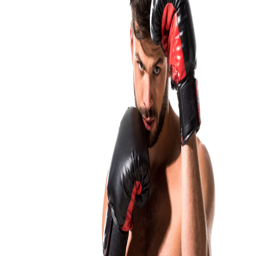
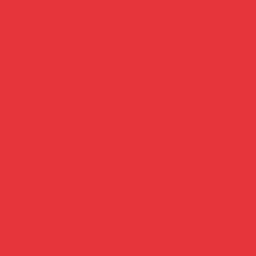
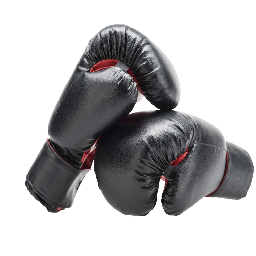
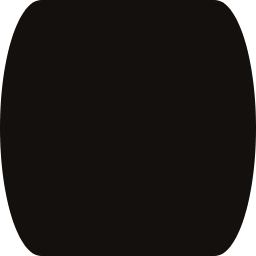
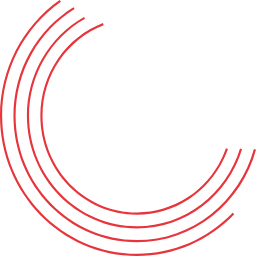
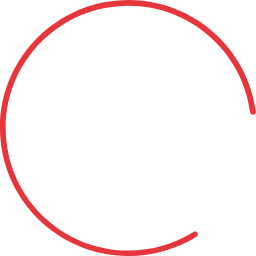
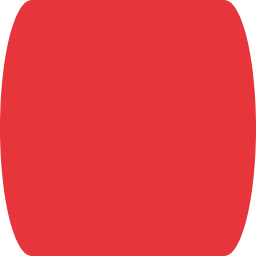
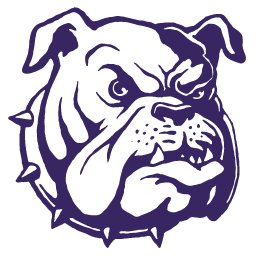
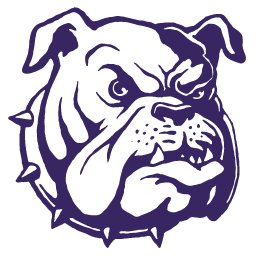
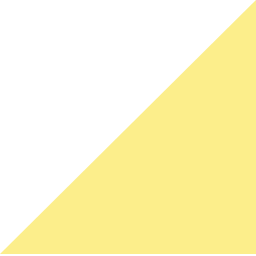
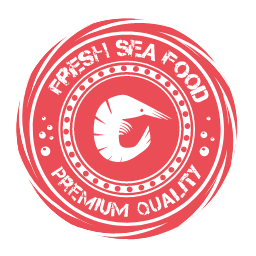
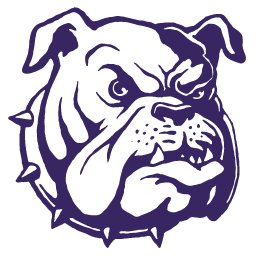
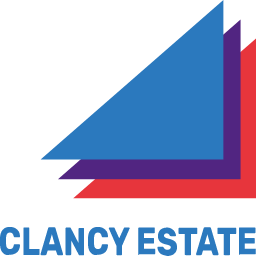
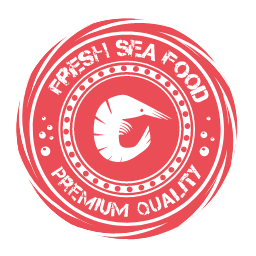
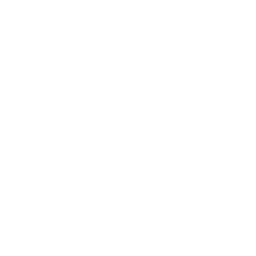
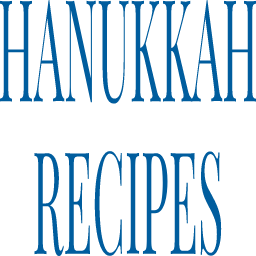


Sample 1:



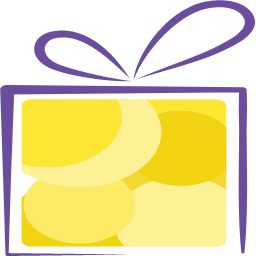
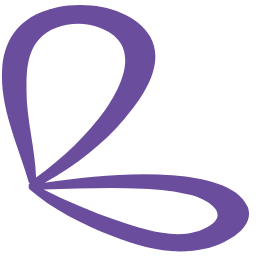
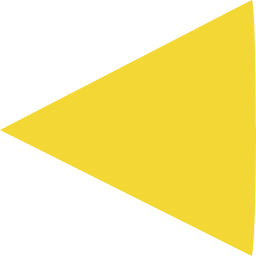
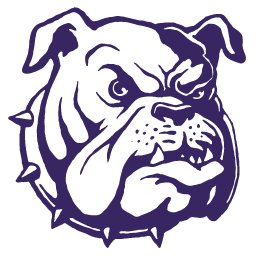
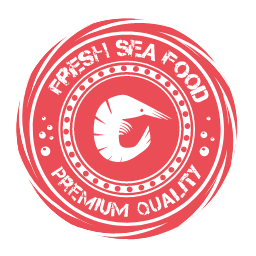
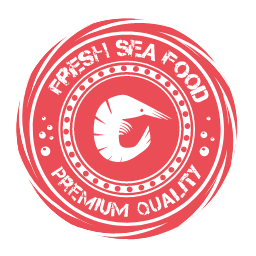
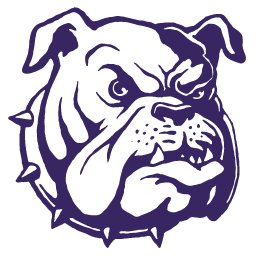
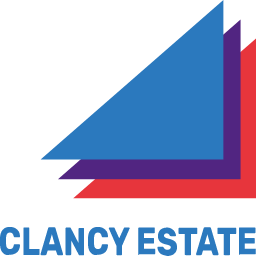


Sample 2:



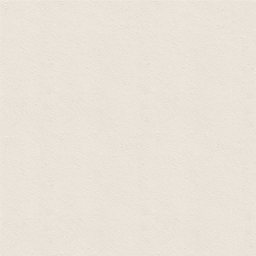
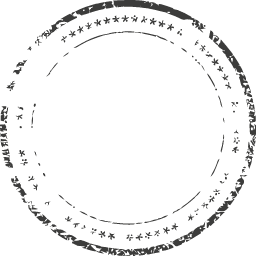
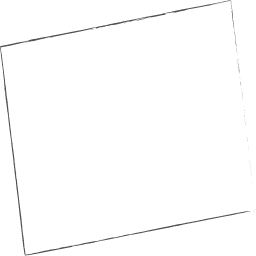
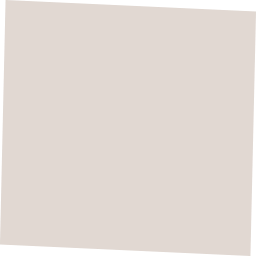
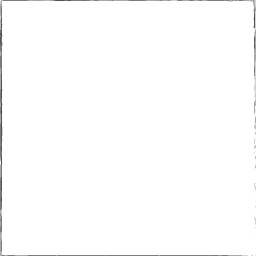
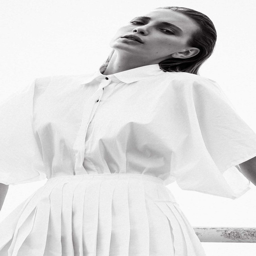
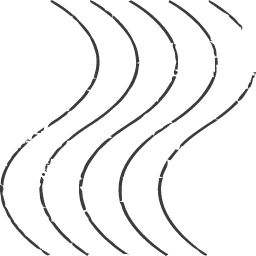
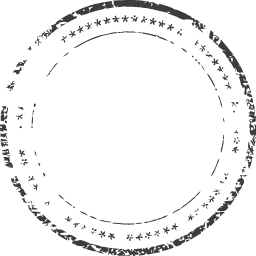
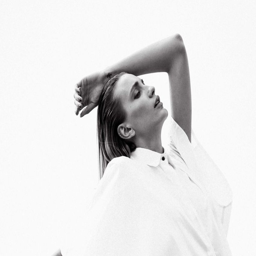
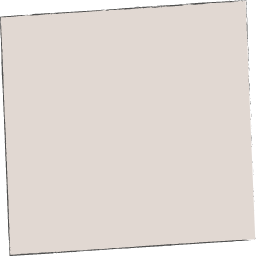
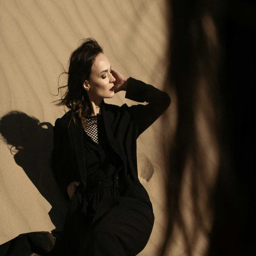
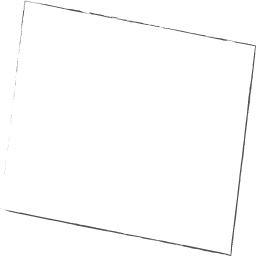
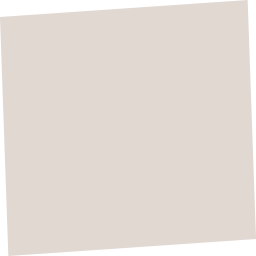
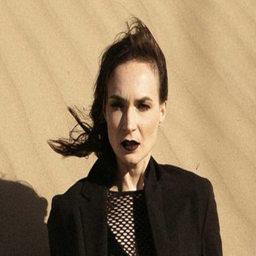
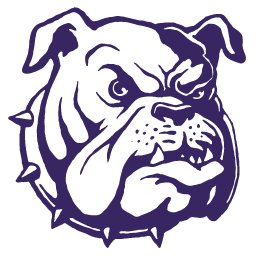
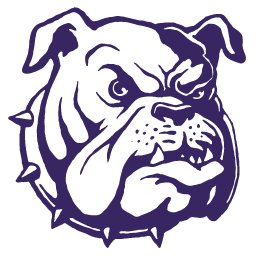
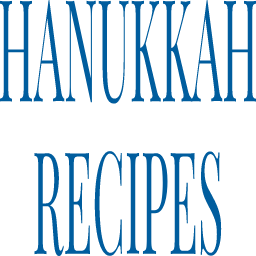
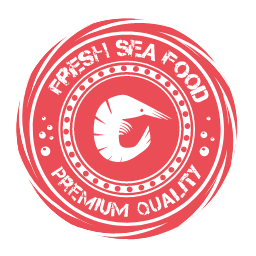
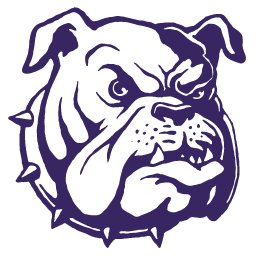
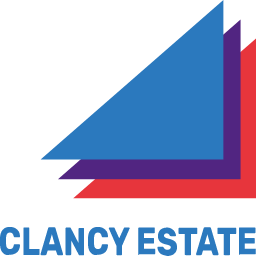
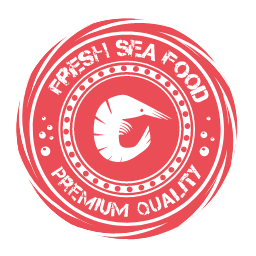
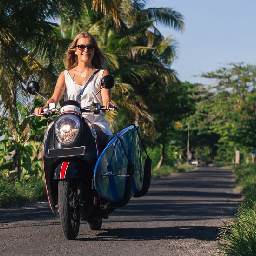
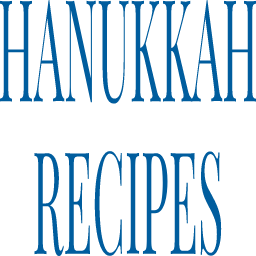
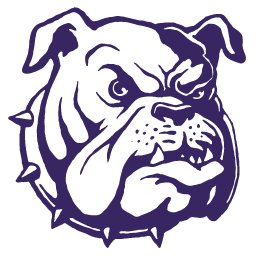
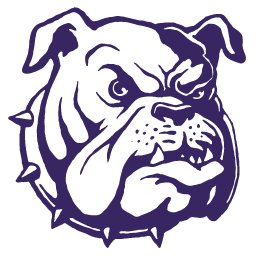
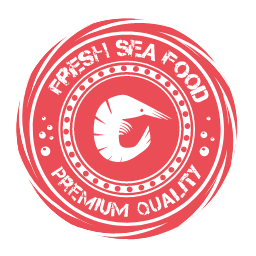
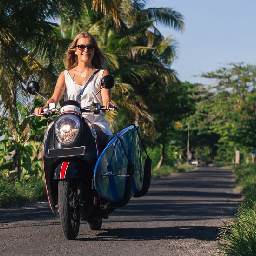
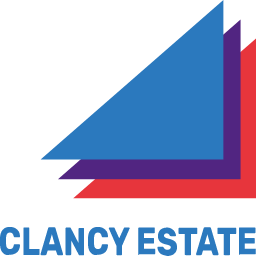
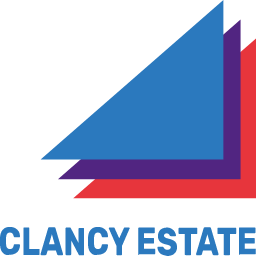
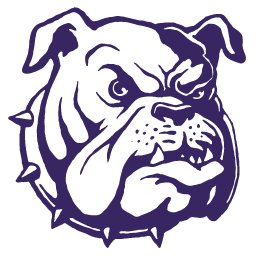


✓ Demo完成!


In [1]:
"""
MFP PyTorch Demo - 纯CPU版本
完全禁用CUDA，强制使用CPU
"""

import os
# 🔧 在导入torch之前禁用CUDA
os.environ['CUDA_VISIBLE_DEVICES'] = ''  # 对torch隐藏所有GPU

import json
import logging
from pathlib import Path
from typing import Dict, List, Optional

import torch
import numpy as np
from IPython.display import display, HTML

# 确认CUDA已禁用
print(f"CUDA可用: {torch.cuda.is_available()}")  # 应该是False
print(f"设备数量: {torch.cuda.device_count()}")  # 应该是0

from models_pytorch import MFP
from dataset import DesignLayoutDataset
from svg_builder_pytorch import SVGBuilder
from retriever_pytorch import ImageRetriever, TextRetriever

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

torch.manual_seed(0)
np.random.seed(0)

print("✓ 导入完成（CPU模式）\n")


# ============================================================
# 配置
# ============================================================
class DemoConfig:
    def __init__(self):
        self.ckpt_dir = "/home/dell/Project-HCL/BaseLine/flexdm_pt/chechpoints"
        self.dataset_name = "crello_json"
        self.db_root = "/home/dell/Project-HCL/BaseLine/flexdm_pt/data/crello_json"
        self.batch_size = 4
        self.device = 'cpu'  # 强制CPU
        self.target_task = "pos"
        
        self.column_names = {
            "txt": ["gt-layout", "gt-visual", "input", "pred"],
            "img": ["gt-layout", "gt-visual", "input", "pred"],
            "attr": ["gt-layout", "gt-visual", "input", "pred"],
            "pos": ["gt-layout", "gt-visual", "pred-layout", "pred-visual"],
            "elem": ["gt-layout", "gt-visual", "input-layout", "input-visual", 
                     "pred-layout", "pred-visual"],
        }
        
        self.attribute_groups = {
            "type": ["type"],
            "pos": ["left", "top", "width", "height"],
            "attr": ["opacity", "color", "font_family"],
            "img": ["image_embedding"],
            "txt": ["text_embedding"],
        }

config = DemoConfig()
print(f"✓ 配置: device={config.device}, batch_size={config.batch_size}\n")


# ============================================================
# 类型映射
# ============================================================
DEFAULT_TYPE_MAPPING = {
    0: '', 1: 'svgElement', 2: 'textElement', 3: 'imageElement',
    4: 'coloredBackground', 5: 'maskElement', 6: 'humanElement',
}

def load_type_mapping_from_vocab(vocab_file: str):
    return DEFAULT_TYPE_MAPPING

def load_font_mapping_from_dataset(dataset):
    return dataset.idx_to_font if hasattr(dataset, 'idx_to_font') else {}

def load_canvas_mappings_from_dataset(dataset):
    width_mapping = dataset.idx_to_width if hasattr(dataset, 'idx_to_width') else {}
    height_mapping = dataset.idx_to_height if hasattr(dataset, 'idx_to_height') else {}
    return width_mapping, height_mapping


# ============================================================
# 数据处理工具
# ============================================================
def _extract_scalar(tensor):
    if tensor.dim() == 0:
        return tensor.item()
    elif tensor.dim() == 1:
        return tensor[0].item() if tensor.size(0) == 1 else tensor.argmax().item()
    else:
        return tensor.argmax(dim=-1)[0].item() if tensor.size(0) > 0 else 0


def tensor_to_list(data, type_mapping, font_mapping=None, 
                   width_mapping=None, height_mapping=None, bins=64):
    batch_size = data['length'].size(0)
    items = []
    scale = 1.0 / (bins - 1.0)
    
    for i in range(batch_size):
        # Canvas尺寸
        canvas_w = 800
        canvas_h = 600
        
        if 'canvas_width' in data:
            width_idx = data['canvas_width'][i].item()
            if width_mapping and width_idx in width_mapping:
                canvas_w = width_mapping[width_idx]
        
        if 'canvas_height' in data:
            height_idx = data['canvas_height'][i].item()
            if height_mapping and height_idx in height_mapping:
                canvas_h = height_mapping[height_idx]
        
        item = {
            'id': data['id'][i] if 'id' in data else f'sample_{i}',
            'canvas_width': canvas_w,
            'canvas_height': canvas_h,
            'length': data['length'][i].item(),
            'elements': []
        }
        
        for j in range(item['length']):
            element = {}
            
            for key, value in data.items():
                if key in ['id', 'length', 'canvas_width', 'canvas_height']:
                    continue
                if not torch.is_tensor(value):
                    continue
                if value.dim() < 2 or value.size(1) <= j:
                    continue
                
                elem_value = value[i, j]
                
                if key == 'type':
                    element[key] = type_mapping.get(int(_extract_scalar(elem_value)), '')
                elif key == 'font_family' and font_mapping:
                    element[key] = font_mapping.get(int(_extract_scalar(elem_value)), 'Arial')
                elif key in ['left', 'top', 'width', 'height']:
                    discrete_idx = _extract_scalar(elem_value)
                    element[key] = float(np.clip(scale * discrete_idx, 0.0, 1.0))
                elif key == 'color':
                    # 处理color：需要反离散化
                    # 模型输出shape: (B, S, 3, 16) -> logits
                    if elem_value.dim() == 2 and elem_value.size(0) == 3:
                        # 取argmax得到离散索引 (3,) 每个值在0-15
                        discrete_indices = elem_value.argmax(dim=-1).cpu().numpy()
                        # 反离散化到0-255
                        rgb = [int(idx * 255 / 15) for idx in discrete_indices]
                        element[key] = rgb
                    elif elem_value.dim() == 1 and elem_value.size(0) == 3:
                        # 已经是离散索引
                        rgb = [int(idx * 255 / 15) for idx in elem_value.cpu().numpy()]
                        element[key] = rgb
                    else:
                        element[key] = [128, 128, 128]
                elif key == 'opacity':
                    # 反离散化：0-7 -> 0.0-1.0
                    discrete_idx = _extract_scalar(elem_value)
                    element[key] = float(discrete_idx / 7.0)
                elif 'embedding' in key:
                    element[key] = elem_value.cpu().numpy()
                elif key == 'uuid':
                    element[key] = str(_extract_scalar(elem_value))
                else:
                    element[key] = _extract_scalar(elem_value)
            
            item['elements'].append(element)
        
        items.append(item)
    
    return items


def get_seq_mask(lengths, max_len=None):
    if lengths.dim() == 2:
        lengths = lengths.squeeze(-1)
    if max_len is None:
        max_len = lengths.max().item()
    mask = torch.arange(max_len, device=lengths.device).unsqueeze(0) < lengths.unsqueeze(1)
    return mask


def get_initial_masks(input_columns, seq_mask):
    masks = {}
    batch_size, seq_len = seq_mask.shape
    for key, column in input_columns.items():
        if column.get('is_sequence', False):
            masks[key] = torch.zeros_like(seq_mask, dtype=torch.bool)
        else:
            masks[key] = torch.ones(batch_size, dtype=torch.bool)
    return masks


def set_visual_default(item):
    item = item.copy()
    for elem in item.get('elements', []):
        elem.setdefault('color', [128, 128, 128])
        elem.setdefault('opacity', 1.0)
        elem.setdefault('font_family', 'Arial')
    return item


# ============================================================
# 模型相关（纯CPU版本）
# ============================================================
def load_model(checkpoint_path, input_columns):
    """加载模型 - 强制CPU"""
    print(f"加载模型: {checkpoint_path}")
    
    model = MFP(
        input_columns=input_columns,
        embed_dim=256,
        num_blocks=4,
        num_heads=8,
        dropout=0.1,
    )
    
    # 强制加载到CPU
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    state_dict = checkpoint.get('state_dict', checkpoint)
    
    missing, unexpected = model.load_state_dict(state_dict, strict=False)
    
    if missing:
        print(f"  警告: 缺失 {len(missing)} 个键")
    if unexpected:
        print(f"  警告: 多余 {len(unexpected)} 个键")
    
    model.eval()
    print("✓ 模型加载完成（CPU）\n")
    return model


def apply_task_masks(example, input_columns, target_task, attribute_groups):
    seq_mask = get_seq_mask(example['length'], example['left'].size(1))
    mfp_masks = get_initial_masks(input_columns, seq_mask)
    
    for key in mfp_masks.keys():
        if not input_columns[key].get('is_sequence', False):
            continue
        
        mask = mfp_masks[key].clone()
        
        if target_task == "elem":
            mask[:, 0] = True
        else:
            if key != "type" and target_task in attribute_groups:
                if key in attribute_groups[target_task]:
                    mask = seq_mask.clone()
        
        mfp_masks[key] = mask
    
    return mfp_masks


def model_inference_with_masks(model, inputs, masks):
    """模型推理 - 纯CPU"""
    masked_inputs = {}
    
    for key, value in inputs.items():
        if key in masks and torch.is_tensor(value):
            mask = masks[key]
            if mask.any():
                masked_value = value.clone()
                if value.dim() == 3:
                    masked_value[mask] = 0
                masked_inputs[key] = masked_value
            else:
                masked_inputs[key] = value
        else:
            masked_inputs[key] = value
    
    # 确保所有数据在CPU上
    for key in masked_inputs:
        if torch.is_tensor(masked_inputs[key]):
            masked_inputs[key] = masked_inputs[key].cpu()
    
    outputs = model(masked_inputs)
    return outputs


# ============================================================
# 可视化主函数
# ============================================================
def visualize_reconstruction(model, example, builders, config, input_columns,
                            type_mapping, font_mapping=None, width_mapping=None, 
                            height_mapping=None, bins=64):
    svgs = []
    target_task = config.target_task
    
    # 确保数据在CPU
    for key in example:
        if torch.is_tensor(example[key]):
            example[key] = example[key].cpu()
    
    items = tensor_to_list(example, type_mapping, font_mapping, 
                          width_mapping, height_mapping, bins)
    
    print(f"渲染 {len(items)} 个样本...")
    
    # GT
    print("  - GT Layout")
    svgs.append([builders["layout"](item) for item in items])
    print("  - GT Visual")
    svgs.append([builders["visual"](item) for item in items])
    
    # 输入视图
    if target_task == "txt":
        print("  - Input (无文本)")
        svgs.append([builders["visual_wo_text"](item) for item in items])
    elif target_task == "img":
        print("  - Input (无图像)")
        svgs.append([builders["visual_wo_image"](item) for item in items])
    elif target_task == "attr":
        print("  - Input (默认属性)")
        svgs.append([builders["visual"](set_visual_default(item)) for item in items])
    
    # 掩码
    mfp_masks = apply_task_masks(example, input_columns, target_task, 
                                 config.attribute_groups)
    
    # 元素级任务
    if target_task == "elem":
        example_copy = {}
        for key, value in example.items():
            if isinstance(value, torch.Tensor) and value.dim() >= 2 and value.size(1) > 1:
                indices = torch.where(~mfp_masks[key][0, :])[0]
                example_copy[key] = torch.index_select(value, 1, indices)
            else:
                example_copy[key] = value
        
        example_copy['length'] = example['length'] - 1
        items_copy = tensor_to_list(example_copy, type_mapping, font_mapping,
                                    width_mapping, height_mapping, bins)
        svgs.append([builders["layout"](item) for item in items_copy])
        svgs.append([builders["visual"](item) for item in items_copy])
    
    # 预测
    print("  - 模型推理")
    with torch.no_grad():
        pred = model_inference_with_masks(model, example, mfp_masks)
    
    for key in example:
        if key not in pred:
            pred[key] = example[key]
    
    pred_items = tensor_to_list(pred, type_mapping, font_mapping,
                                width_mapping, height_mapping, bins)
    
    if target_task in ["pos", "elem"]:
        print("  - Pred Layout")
        svgs.append([builders["layout"](item) for item in pred_items])
    
    print("  - Pred Visual")
    svgs.append([builders["visual"](item) for item in pred_items])
    
    print("✓ 渲染完成\n")
    return list(zip(*svgs))


# ============================================================
# 主流程
# ============================================================
print("="*80)
print("MFP PyTorch Demo - 纯CPU版本")
print("="*80)

# 1. 加载数据集
print("\n1. 加载数据集")
dataset = DesignLayoutDataset(config.db_root, split='test', max_length=20)
print(f"✓ 数据集大小: {len(dataset)}\n")

# 2. 加载映射
print("2. 加载映射")
vocab_file = Path(config.db_root).parent / "vocabulary.json"
type_mapping = load_type_mapping_from_vocab(str(vocab_file))
font_mapping = load_font_mapping_from_dataset(dataset)
width_mapping, height_mapping = load_canvas_mappings_from_dataset(dataset)

if font_mapping:
    print(f"✓ 字体映射: {len(font_mapping)} 个字体")
if width_mapping:
    print(f"✓ Width映射: {len(width_mapping)} 个尺寸")
if height_mapping:
    print(f"✓ Height映射: {len(height_mapping)} 个尺寸")
print()

# 3. 创建DataLoader
print("3. 创建DataLoader")
from torch.utils.data import DataLoader
from dataset import collate_fn

dataloader = DataLoader(dataset, batch_size=config.batch_size, 
                       shuffle=False, collate_fn=collate_fn)
example = next(iter(dataloader))

# 强制转CPU
for key in example:
    if torch.is_tensor(example[key]):
        example[key] = example[key].cpu()

print(f"✓ 批次形状: {example['left'].shape}\n")

# 4. 加载配置
print("4. 加载模型配置")
input_columns_file = './input_columns_generated.json'
with open(input_columns_file, 'r') as f:
    input_columns = json.load(f)
print(f"✓ 输入列数: {len(input_columns)}\n")

# 5. 加载模型
print("5. 加载模型")
checkpoint_path = Path(config.ckpt_dir) / "best_pytorch.pth"
model = load_model(str(checkpoint_path), input_columns)

# 6. 构建检索数据库
print("6. 构建检索数据库")
db_root = Path(config.db_root).parent / config.dataset_name
image_db = ImageRetriever(db_root, image_path=db_root / "images")
image_db.build("test")
text_db = TextRetriever(db_root, text_path=db_root / "texts")
text_db.build("test")
print()

# 7. 创建SVG构建器
print("7. 创建SVG构建器")
builders = {
    "layout": SVGBuilder(key='type', max_width=128, max_height=192, opacity=0.8),
    "visual": SVGBuilder(key='color', max_width=128, max_height=192, 
                        image_db=image_db, text_db=text_db, 
                        render_text=True, opacity=1.0),
    "visual_wo_text": SVGBuilder(key='color', max_width=128, max_height=192,
                                 image_db=image_db, text_db=None, 
                                 render_text=False, opacity=1.0),
    "visual_wo_image": SVGBuilder(key='color', max_width=128, max_height=192,
                                  image_db=None, text_db=text_db, 
                                  render_text=True, opacity=1.0),
}
print("✓ 构建器创建完成\n")

# 8. 运行可视化
print("="*80)
print(f"8. 开始可视化 - 任务: {config.target_task}")
print("="*80)

svgs = visualize_reconstruction(model, example, builders, config, input_columns,
                                type_mapping, font_mapping, width_mapping, 
                                height_mapping, bins=64)

print(f"✓ 生成了 {len(svgs)} 个样本的可视化结果")
print(f"列名: {config.column_names[config.target_task]}\n")

# 9. 显示结果
print("="*80)
print("可视化结果:")
print("="*80)

for i, row in enumerate(svgs[:3]):
    print(f"\nSample {i}:")
    display(HTML("<div style='margin: 10px 0;'>%s</div>" % " ".join(row)))

print("\n✓ Demo完成!")